In [1]:
import os
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# From huggingface api, with our trained adapters (eu, sr)
existing_adapters = [
    "th",
    "my",
    "hi",
    "ilo",
    "ht",
    "tr",
    "mi",
    "vi",
    "is",
    "it",
    "ta",
    "jv",
    "ja",
    "sw",
    "qu",
    "de",
    "el",
    "et",
    "ru",
    "gn",
    "id",
    "en",
    "ar",
    "es",
    "tk",
    "zh",
    "mhr",
    "cdo",
    "xmf",
    "eu",
    "sr",
]
# scraped from cc-100 website
xlm_included_langs = [
    "af",
    "am",
    "ar",
    "as",
    "az",
    "be",
    "bg",
    "bn",
    "br",
    "bs",
    "ca",
    "cs",
    "cy",
    "da",
    "de",
    "el",
    "en",
    "eo",
    "es",
    "et",
    "eu",
    "fa",
    "ff",
    "fi",
    "fr",
    "fy",
    "ga",
    "gd",
    "gl",
    "gn",
    "gu",
    "ha",
    "he",
    "hi",
    "hr",
    "ht",
    "hu",
    "hy",
    "id",
    "ig",
    "is",
    "it",
    "ja",
    "jv",
    "ka",
    "kk",
    "km",
    "kn",
    "ko",
    "ku",
    "ky",
    "la",
    "lg",
    "li",
    "ln",
    "lo",
    "lt",
    "lv",
    "mg",
    "mk",
    "ml",
    "mn",
    "mr",
    "ms",
    "my",
    "ne",
    "nl",
    "no",
    "ns",
    "om",
    "or",
    "pa",
    "pl",
    "ps",
    "pt",
    "qu",
    "rm",
    "ro",
    "ru",
    "sa",
    "si",
    "sc",
    "sd",
    "sk",
    "sl",
    "so",
    "sq",
    "sr",
    "ss",
    "su",
    "sv",
    "sw",
    "ta",
    "te",
    "th",
    "tl",
    "tn",
    "tr",
    "ug",
    "uk",
    "ur",
    "uz",
    "vi",
    "wo",
    "xh",
    "yi",
    "yo",
    "zu",
    "zh",
]
f1 = {"ner": "eval_f1", "copa": "eval_acc", "pos": "eval_f1_macro", "qa": "f1", "sib": "eval_accuracy"}
scores = {task: {} for task in f1.keys()}
tasks = list(f1.keys())
inf = math.inf
for file in os.listdir("../eval_scores/selected"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../eval_scores/selected", file), "r") as f:
                data = json.load(f)
                task_name = file.split(".")[0]

                scores[task_name] = data

        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)

# we rename all keys
renames = {
    "reconstructed_featural": "TIPA",
    "baseline_en": "English language adapter",
    "baseline_closest_featural": "MAD-X",
    "finetune": "Fine-tuning",
    "no_train_gain": "No Train but Gain",
    "baseline_avg_adapter": "Parameter averaging",
}
scores_renamed = {}
for task in scores:
    scores_renamed[task] = {}
    for lang, keys in scores[task].items():
        scores_renamed[task][lang] = {}
        for key, score in scores[task][lang].items():
            if key in renames.keys():
                scores_renamed[task][lang][renames[key]] = score
old_scores = scores
scores = scores_renamed


langs = set()
for task in tasks:
    for lang_name in scores[task]:
        if "TIPA" not in scores[task][lang_name].keys():
            continue
        langs.add(lang_name)
print("langs", len(langs))
# we remove all languages from score that are not in langs
for task_name in scores:
    for lang_name in list(scores[task_name].keys()):
        if lang_name not in langs:
            del scores[task_name][lang_name]
# we make a subset consisting of only the languages for which an adapter exists
with_adapter = {}
no_adapter = {}
for task_name in scores:
    with_adapter[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            with_adapter[task_name][lang_name] = scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = scores[task_name][lang_name]
token_overlap = {}
for file in os.listdir("../data/token_overlap"):
    if file.endswith(".json"):
        try:
            with open(os.path.join("../data/token_overlap", file), "r") as f:
                data = json.load(f)
                task_name = file.split("_")[0]
                token_overlap[task_name] = data
        except json.JSONDecodeError:
            print(f"Error decoding JSON for file: {file}")
        except KeyError:
            print("KeyError:", file)


print("total languages:", len(langs))
all_adapters = set()
all_no_adapters = set()
all_xlm_included = set()
all_xlm_not_included = set()
for task in tasks:
    for lang_name in scores[task]:
        if lang_name in existing_adapters:
            all_adapters.add(lang_name)
        else:
            all_no_adapters.add(lang_name)
        if lang_name in xlm_included_langs:
            all_xlm_included.add(lang_name)
        else:
            all_xlm_not_included.add(lang_name)
print("languages with a trained adapter:", len(all_adapters))
print("languages without a trained adapter:", len(all_no_adapters))
print("languages in the xlm included languages:", len(all_xlm_included))
print("languages not in the xlm included languages:", len(all_xlm_not_included))

for task in tasks:
    print(f"task: {task}, {len(set(scores[task]).intersection(langs))} languages")
    print(
        f"{len(set(with_adapter[task]).intersection(langs))} have a trained language adapter, {len(set(no_adapter[task]).intersection(langs))} not"
    )
    print(
        f"{len(set(xlm_included[task]).intersection(langs))} are in the xlm included languages, {len(set(xlm_not_included[task]).intersection(langs))} not"
    )
    # we make a list of all languages

langs 234
total languages: 234
languages with a trained adapter: 31
languages without a trained adapter: 203
languages in the xlm included languages: 95
languages not in the xlm included languages: 139
task: ner, 136 languages
30 have a trained language adapter, 106 not
86 are in the xlm included languages, 50 not
task: copa, 11 languages
11 have a trained language adapter, 0 not
11 are in the xlm included languages, 0 not
task: pos, 80 languages
19 have a trained language adapter, 61 not
57 are in the xlm included languages, 23 not
task: qa, 12 languages
11 have a trained language adapter, 1 not
12 are in the xlm included languages, 0 not
task: sib, 176 languages
25 have a trained language adapter, 151 not
81 are in the xlm included languages, 95 not


{'ar': {'Fine-tuning': 0.4844257340257937,
  'TIPA': 0.5441332489005462,
  'English language adapter': 0.5361632139979524,
  'Parameter averaging': 0.5241715248402827,
  'MAD-X': 0.547615222489753,
  'No Train but Gain': 0.5709762382838557},
 'de': {'Fine-tuning': 0.6935683136757096,
  'TIPA': 0.7418050742826959,
  'English language adapter': 0.7371992953875801,
  'Parameter averaging': 0.7404560022423078,
  'MAD-X': 0.7496306719722793,
  'No Train but Gain': 0.7433196531428476},
 'el': {'Fine-tuning': 0.5937929402642674,
  'TIPA': 0.6061122962271579,
  'English language adapter': 0.6093770242415579,
  'Parameter averaging': 0.5923867570967204,
  'MAD-X': 0.5910083639082109,
  'No Train but Gain': 0.6079787309202458},
 'en': {'Fine-tuning': 0.8249745055187148,
  'TIPA': 0.825467949900416,
  'English language adapter': 0.8349177948980061,
  'Parameter averaging': 0.823025867862313,
  'MAD-X': 0.8349177948980061,
  'No Train but Gain': 0.8346309763817327},
 'es': {'Fine-tuning': 0.625689

In [2]:
# we make a copy of no_adapter in which we change the name of "MAD-X" to "Closest Adapter"
no_adapter_closest = {}
for task in no_adapter:
    no_adapter_closest[task] = {}
    for language in no_adapter[task]:
        no_adapter_closest[task][language] = {}
        for key, score in no_adapter[task][language].items():
            if key == "MAD-X":
                no_adapter_closest[task][language]["Closest adapter"] = score
            else:
                no_adapter_closest[task][language][key] = score
scores_closest = {}
for task in scores:
    scores_closest[task] = {}
    for language in scores[task]:
        scores_closest[task][language] = {}
        for key, score in scores[task][language].items():
            if key == "MAD-X" and language not in existing_adapters:
                scores_closest[task][language]["Closest adapter"] = score
            else:
                scores_closest[task][language][key] = score

In [3]:
no_adapter

{'ner': {'ace': {'Fine-tuning': 0.20911528150134046,
   'TIPA': 0.36423841059602646,
   'English language adapter': 0.3344262295081967,
   'Parameter averaging': 0.27272727272727276,
   'MAD-X': 0.3958333333333333,
   'No Train but Gain': 0.3879598662207358},
  'af': {'Fine-tuning': 0.6343397377249161,
   'TIPA': 0.7266584766584767,
   'English language adapter': 0.7029702970297029,
   'Parameter averaging': 0.6690163409163731,
   'MAD-X': 0.6592661116250385,
   'No Train but Gain': 0.7144607843137256},
  'als': {'Fine-tuning': 0.35804701627486435,
   'TIPA': 0.6063157894736841,
   'English language adapter': 0.5872340425531913,
   'Parameter averaging': 0.5277777777777778,
   'MAD-X': 0.5678496868475991,
   'No Train but Gain': 0.5865580448065173},
  'am': {'Fine-tuning': 0.3352601156069364,
   'TIPA': 0.36781609195402293,
   'English language adapter': 0.25274725274725274,
   'Parameter averaging': 0.32888888888888884,
   'MAD-X': 0.1588785046728972,
   'No Train but Gain': 0.3629343

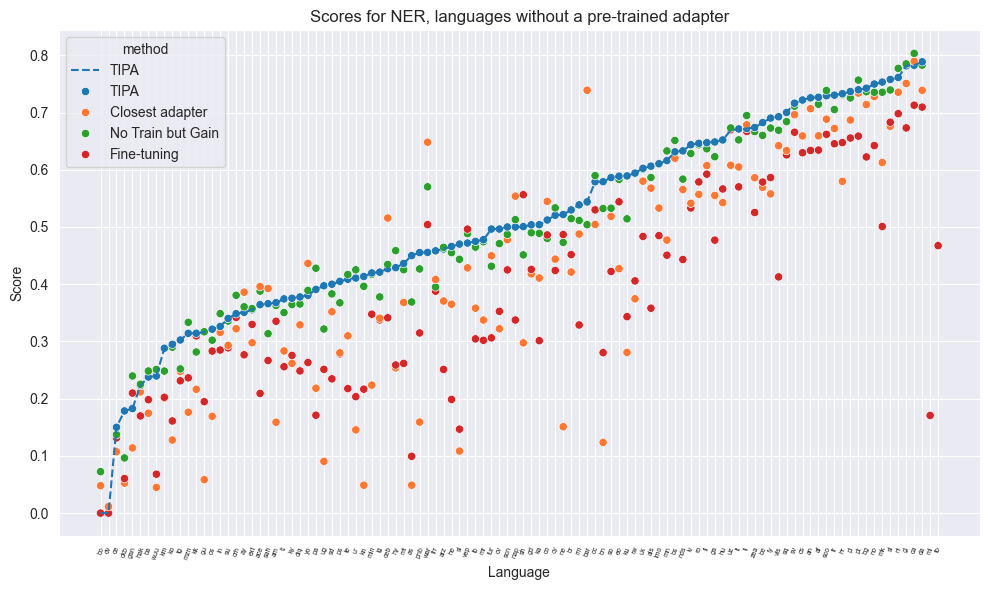

In [4]:
# we make a lineplot of the scores for different tasks
# the scores should be sorted from lowest to highest for reconstructed_featural, with a line connecting the points
# we define a global palette and hue‐order so different runs have the same colors
METHODS = [
    "TIPA",
    "MAD-X",
    "Closest adapter",
    "No Train but Gain",
    "Fine-tuning",
]
PALETTE = {
    "TIPA": "#1f77b4",  # blue
    "MAD-X": "#ffdf0e",  # orange
    "Closest adapter": "#ff7733",
    "No Train but Gain": "#2ca02c",  # green
    "Fine-tuning": "#d62728",  # red
}


def custom_plot(
    task_name,
    column,
    save=False,
    dataframe=scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
):
    data = []
    for lang_name in dataframe[task_name]:
        if column in dataframe[task_name][lang_name]:
            data.append([task_name, lang_name, dataframe[task_name][lang_name][column], column])
        for baseline in baselines:
            if baseline in dataframe[task_name][lang_name]:
                data.append([task_name, lang_name, dataframe[task_name][lang_name][baseline], baseline])
    df = pd.DataFrame(data, columns=["task", "lang_name", "score", "method"])
    df = df.sort_values(by=["score"])
    plt.figure(figsize=(10, 6))
    main = df[df.method == column]
    plt.plot(main.lang_name, main.score, linestyle="--", color=PALETTE[column], label=column)
    if plot_type == "line":
        sns.lineplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
            marker="o",
        )
    elif plot_type == "scatter":
        sns.scatterplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
        )
        # we add a line only for reconstructed_featural

    plt.title(f"Scores for {task_name.upper()}, languages without a pre-trained adapter")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=70, size=5)
    plt.tight_layout()
    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot(
    "ner",
    "TIPA",
    dataframe=no_adapter_closest,
    save="no_adapter",
    plot_type="scatter",
    baselines=["Fine-tuning", "Closest adapter", "No Train but Gain"],
)

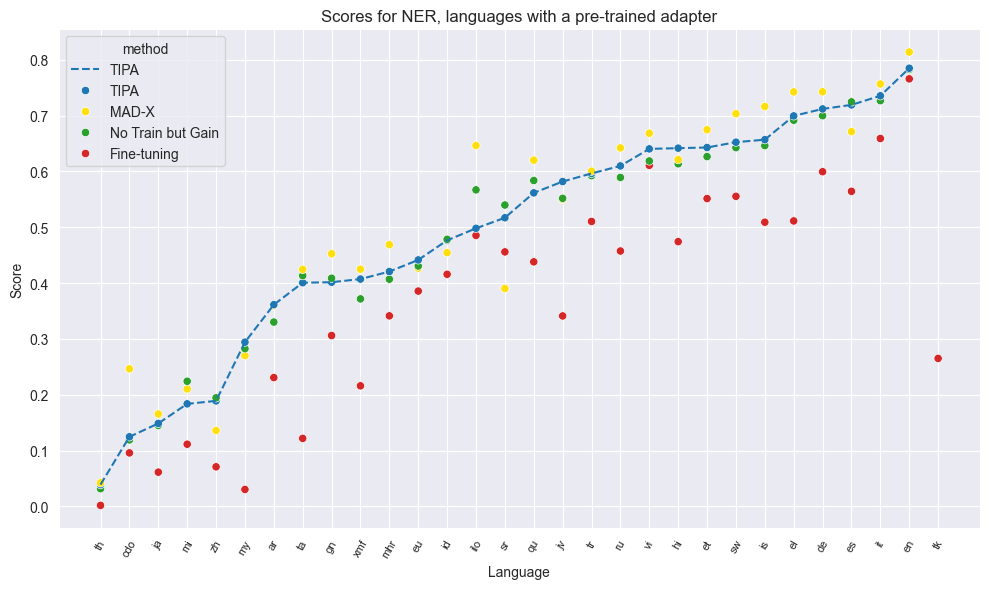

In [5]:
# we make a lineplot of the scores for different tasks
# the scores should be sorted from lowest to highest for reconstructed_featural, with a line connecting the points
# we define a global palette and hue‐order so different runs have the same colors
METHODS = [
    "TIPA",
    "MAD-X",
    "Closest adapter",
    "No Train but Gain",
    "Fine-tuning",
]
PALETTE = {
    "TIPA": "#1f77b4",  # blue
    "MAD-X": "#ffdf0e",  # orange
    "Closest adapter": "#ff7733",
    "No Train but Gain": "#2ca02c",  # green
    "Fine-tuning": "#d62728",  # red
}


def custom_plot(
    task_name,
    column,
    save=False,
    dataframe=scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
):
    data = []
    for lang_name in dataframe[task_name]:
        if column in dataframe[task_name][lang_name]:
            data.append([task_name, lang_name, dataframe[task_name][lang_name][column], column])
        for baseline in baselines:
            if baseline in dataframe[task_name][lang_name]:
                data.append([task_name, lang_name, dataframe[task_name][lang_name][baseline], baseline])
    df = pd.DataFrame(data, columns=["task", "lang_name", "score", "method"])
    df = df.sort_values(by=["score"])
    plt.figure(figsize=(10, 6))
    main = df[df.method == column]
    plt.plot(main.lang_name, main.score, linestyle="--", color=PALETTE[column], label=column)
    if plot_type == "line":
        sns.lineplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
            marker="o",
        )
    elif plot_type == "scatter":
        sns.scatterplot(
            x="lang_name",
            y="score",
            hue="method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            data=df,
        )
        # we add a line only for reconstructed_featural

    plt.title(f"Scores for {task_name.upper()}, languages with a pre-trained adapter")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=60, size=8)
    plt.tight_layout()
    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot(
    "ner",
    "TIPA",
    dataframe=with_adapter,
    save="with_adapter",
    plot_type="scatter",
    baselines=["Fine-tuning", "MAD-X", "No Train but Gain"],
)

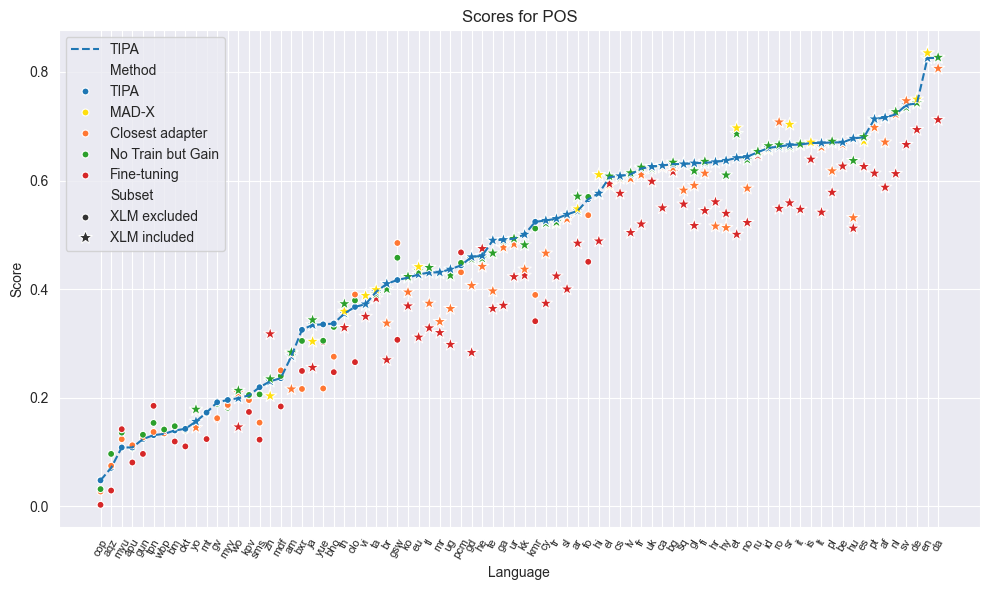

In [6]:
def custom_plot_with_figure(
    task_name,
    column,
    dataframe,
    subset_scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
    save=False,
):
    # 1) collect all methods + record which subset each lang comes from
    data = []
    for lang in dataframe[task_name]:
        # figure out which “subset” this is
        subset_label = "XLM included" if lang in subset_scores.get(task_name, {}) else "XLM excluded"
        # main metric
        if column in dataframe[task_name][lang]:
            data.append([lang, dataframe[task_name][lang][column], column, subset_label])
        # baselines
        for baseline in baselines:
            if baseline in dataframe[task_name][lang]:
                data.append([lang, dataframe[task_name][lang][baseline], baseline, subset_label])
    df = pd.DataFrame(data, columns=["lang", "score", "Method", "Subset"])
    df = df.sort_values("score")

    plt.figure(figsize=(10, 6))
    # dashed line for the main metric
    main = df[df.Method == column]
    plt.plot(main.lang, main.score, linestyle="--", color=PALETTE[column], label=column)

    if plot_type == "line":
        sns.lineplot(
            x="lang",
            y="score",
            hue="Method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            style="Subset",
            data=df,
            markers=True,
            dashes=False,
        )
    else:  # scatter
        sns.scatterplot(
            x="lang",
            y="score",
            hue="Method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            style="Subset",
            data=df,
            markers={"XLM excluded": ".", "XLM included": "*"},
            s=100,
        )

    plt.title(f"Scores for {task_name.upper()}")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=60, fontsize=8)
    plt.tight_layout()

    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot_with_figure(
    "pos",
    "TIPA",
    dataframe=scores_closest,
    subset_scores=xlm_included,
    save="xlm",
    plot_type="scatter",
    baselines=["Fine-tuning", "MAD-X", "Closest adapter", "No Train but Gain"],
)

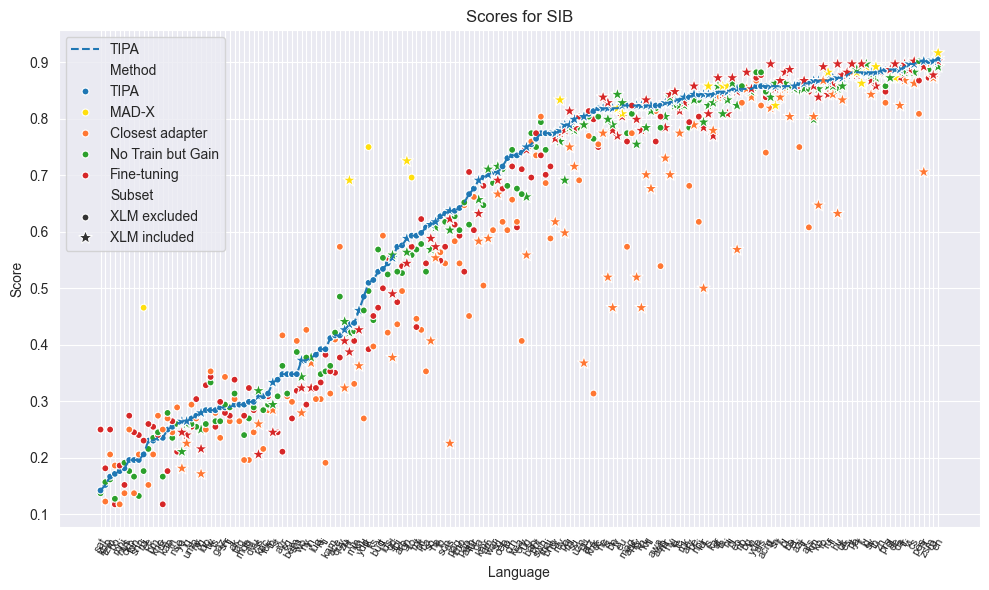

In [7]:
def custom_plot_with_figure(
    task_name,
    column,
    dataframe,
    subset_scores,
    plot_type="line",
    baselines=["Fine-tuning", "No Train but Gain", "MAD-X"],
    save=False,
):
    # 1) collect all methods + record which subset each lang comes from
    data = []
    for lang in dataframe[task_name]:
        # figure out which “subset” this is
        subset_label = "XLM included" if lang in subset_scores.get(task_name, {}) else "XLM excluded"
        # main metric
        if column in dataframe[task_name][lang]:
            data.append([lang, dataframe[task_name][lang][column], column, subset_label])
        # baselines
        for baseline in baselines:
            if baseline in dataframe[task_name][lang]:
                data.append([lang, dataframe[task_name][lang][baseline], baseline, subset_label])
    df = pd.DataFrame(data, columns=["lang", "score", "Method", "Subset"])
    df = df.sort_values("score")

    plt.figure(figsize=(10, 6))
    # dashed line for the main metric
    main = df[df.Method == column]
    plt.plot(main.lang, main.score, linestyle="--", color=PALETTE[column], label=column)

    if plot_type == "line":
        sns.lineplot(
            x="lang",
            y="score",
            hue="Method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            style="Subset",
            data=df,
            markers=True,
            dashes=False,
        )
    else:  # scatter
        sns.scatterplot(
            x="lang",
            y="score",
            hue="Method",
            hue_order=[el for el in METHODS if el in [column] + baselines],
            palette={k: v for k, v in PALETTE.items() if k in [column] + baselines},
            style="Subset",
            data=df,
            markers={"XLM excluded": ".", "XLM included": "*"},
            s=100,
        )

    plt.title(f"Scores for {task_name.upper()}")
    plt.xlabel("Language")
    plt.ylabel("Score")
    plt.xticks(rotation=60, fontsize=8)
    plt.tight_layout()

    if save:
        plt.savefig(f"../output/{task_name}_{'_'.join(column.split())}_{plot_type}_{save}.pdf", dpi=1000)
    plt.show()


custom_plot_with_figure(
    "sib",
    "TIPA",
    dataframe=scores_closest,
    subset_scores=xlm_included,
    save="xlm",
    plot_type="scatter",
    baselines=["Fine-tuning", "MAD-X", "Closest adapter", "No Train but Gain"],
)

Overall score (Results 

In [8]:
# we present the results for each baseline in a table
# we calculate the mean for each baseline
table_scores = {
    "Reconstruction method": "reconstructed_featural",
    "No Train but Gain": "no_train_gain",
    "English language adapter": "baseline_en",
    "MAD-X": "baseline_closest_featural",
    "Fine-tuning": "finetune",
    "Parameter averaging": "baseline_avg_adapter",
}
baselines = ["TIPA", "No Train but Gain", "English language adapter", "MAD-X", "Fine-tuning", "Parameter averaging"]
means = {}
for baseline in baselines:
    all_scores = []
    for task in tasks:
        for lang_name in scores[task]:
            if baseline in scores[task][lang_name]:
                all_scores.append(scores[task][lang_name][baseline])
    means[baseline] = round(np.mean(all_scores), 3)
# we make a dataframe with the means
means_df = pd.DataFrame(means, index=["Score"]).T
lat = means_df.to_latex()
print(lat)

\begin{tabular}{lr}
\toprule
 & Score \\
\midrule
TIPA & 0.557000 \\
No Train but Gain & 0.548000 \\
English language adapter & 0.524000 \\
MAD-X & 0.503000 \\
Fine-tuning & 0.494000 \\
Parameter averaging & 0.481000 \\
\bottomrule
\end{tabular}


# Overview of scores per task and method

In [12]:
metrics = ["TIPA", "MAD-X", "No Train but Gain", "Fine-tuning"]
subsets = {
    "Overall": scores,
    "No adapter": no_adapter,
    "With adapter": with_adapter,
    "XLM included": xlm_included,
    "XLM excluded": xlm_not_included,
}
# Compute averages
records = []
for task in tasks:
    row = {"task": task}
    for subset_name, subset in subsets.items():
        langs = list(subset[task].keys())
        for metric in metrics:
            values = [subset[task][lang].get(metric, np.nan) for lang in langs]
            row[(subset_name, metric)] = np.nanmean(values) if values else np.nan
    records.append(row)

# Build DataFrame
index = [r["task"].upper() for r in records]
columns = pd.MultiIndex.from_product([list(subsets.keys()), metrics], names=["Subset", "Metric"])
df_avg = pd.DataFrame(
    [[r[(subset, metric)] for subset in subsets for metric in metrics] for r in records], index=index, columns=columns
)

# Display
df_avg.round(4)

Subset Overall                                       No adapter          \
Metric    TIPA   MAD-X No Train but Gain Fine-tuning       TIPA   MAD-X   
NER     0.5013  0.4335            0.4931      0.3896     0.5052  0.4136   
COPA    0.5120  0.5198            0.5031      0.5553        NaN     NaN   
POS     0.4679  0.4461            0.4686      0.4003     0.4404  0.4102   
QA      0.7271  0.7211            0.7253      0.5337     0.7891  0.7660   
SIB     0.6317  0.5652            0.6159      0.6112     0.6067  0.5223   

Subset                               With adapter                            \
Metric No Train but Gain Fine-tuning         TIPA   MAD-X No Train but Gain   
NER               0.4957      0.3947       0.4875  0.5049            0.4839   
COPA                 NaN         NaN       0.5120  0.5198            0.5031   
POS               0.4393      0.3671       0.5564  0.5614            0.5624   
QA                0.7812      0.6239       0.7215  0.7170            0.7202   
SIB               0.5899      0.5854       0.7823  0.8243            0.7726   

Subset             XLM included                                        \
Metric Fine-tuning         TIPA   MAD-X No Train but Gain Fine-tuning   
NER         0.3714       0.5518  0.4689            0.5416      0.4281   
COPA        0.5553       0.5120  0.5198            0.5031      0.5553   
POS         0.5069       0.5595  0.5369            0.5596      0.4831   
QA          0.5255       0.7271  0.7211            0.7253      0.5337   
SIB         0.7673       0.7681  0.6915            0.7543      0.7548   

Subset XLM excluded                                        
Metric         TIPA   MAD-X No Train but Gain Fine-tuning  
NER          0.4120  0.3707            0.4073      0.3234  
COPA            NaN     NaN               NaN         NaN  
POS          0.2409  0.2211            0.2429      0.1950  
QA              NaN     NaN               NaN         NaN  
SIB          0.5154  0.4575            0.4979      0.4888

Per-column coloring

In [13]:
df_table = df_avg.T
# 1) transpose so that Subset×Metric → rows, Tasks → columns
df_table.index.names = ["Subset", "Metric"]


# 3) compute min/median/max for each Task‐column (for the gradient macro)
col_stats = {}

for task in df_table.columns:
    vals = df_table[task].dropna().astype(float)
    mn, md, mx = vals.min(), float(np.median(vals)), vals.max()
    col_stats[task] = (mn, md, mx)

# 4) build a formatter for each Task ==> Per-column color coding
formatters = {}
for task, (mn, md, mx) in col_stats.items():
    formatters[task] = (
        lambda mn, md, mx: lambda x: (f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}" if not pd.isna(x) else "")
    )(mn, md, mx)

# 5) export to LaTeX, using multirow on the Subset level
latex = df_table.to_latex(escape=True, formatters=formatters, multirow=True)
print(latex)

\begin{tabular}{llrrrrr}
\toprule
 &  & NER & COPA & POS & QA & SIB \\
Subset & Metric &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Overall} & TIPA & \tgrad[0.323][0.451][0.552]{0.501} & \tgrad[0.503][0.516][0.555]{0.512} & \tgrad[0.195][0.457][0.562]{0.468} & \tgrad[0.525][0.721][0.789]{0.727} & \tgrad[0.458][0.614][0.824]{0.632} \\
 & MAD-X & \tgrad[0.323][0.451][0.552]{0.433} & \tgrad[0.503][0.516][0.555]{0.520} & \tgrad[0.195][0.457][0.562]{0.446} & \tgrad[0.525][0.721][0.789]{0.721} & \tgrad[0.458][0.614][0.824]{0.565} \\
 & No Train but Gain & \tgrad[0.323][0.451][0.552]{0.493} & \tgrad[0.503][0.516][0.555]{0.503} & \tgrad[0.195][0.457][0.562]{0.469} & \tgrad[0.525][0.721][0.789]{0.725} & \tgrad[0.458][0.614][0.824]{0.616} \\
 & Fine-tuning & \tgrad[0.323][0.451][0.552]{0.390} & \tgrad[0.503][0.516][0.555]{0.555} & \tgrad[0.195][0.457][0.562]{0.400} & \tgrad[0.525][0.721][0.789]{0.534} & \tgrad[0.458][0.614][0.824]{0.611} \\
\cline{1-7}
\multirow[t]{4}{*}{No adapter} & TIPA & \t

column coloring and bold

In [17]:
import numpy as np
import pandas as pd

# 1) transpose so that Subset×Metric → rows, Tasks → columns
df_table = df_avg.T.copy()
df_table.index.names = ["Subset", "Metric"]

# 2) compute [min, median, max] for each Task‐column (for the gradient)
col_stats = {}
for task in df_table.columns:
    vals = pd.to_numeric(df_table[task].values, errors="coerce")
    mn, md, mx = np.nanmin(vals), float(np.nanmedian(vals)), np.nanmax(vals)
    col_stats[task] = (mn, md, mx)

# 3) compute, per‐subset and per‐task, the max value (so we know which to bold)
max_per_subset = df_table.groupby(level=0).max()

# 4) build a new DataFrame of strings, applying both the per‐column gradient and bold on the subset‐max
df_str = df_table.copy().astype(object)

for (subset, metric), row in df_table.iterrows():
    for task in df_table.columns:
        x = row[task]
        if pd.isna(x):
            cell = ""
        else:
            mn, md, mx = col_stats[task]
            # per‐column gradient
            grad = f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}"
            # bold if it's the max within that subset for this task
            if x == max_per_subset.loc[subset, task]:
                cell = f"\\textbf{{{grad}}}"
            else:
                cell = grad
        df_str.at[(subset, metric), task] = cell

# 5) export to LaTeX (allow LaTeX commands through without escaping)
latex = df_str.to_latex(
    escape=False,  # let \tgrad and \textbf pass through
    multirow=True,
)

print(latex)

\begin{tabular}{lllllll}
\toprule
 &  & NER & COPA & POS & QA & SIB \\
Subset & Metric &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Overall} & TIPA & \textbf{\tgrad[0.323][0.451][0.552]{0.501}} & \tgrad[0.503][0.516][0.555]{0.512} & \tgrad[0.195][0.457][0.562]{0.468} & \textbf{\tgrad[0.525][0.721][0.789]{0.727}} & \textbf{\tgrad[0.458][0.614][0.824]{0.632}} \\
 & MAD-X & \tgrad[0.323][0.451][0.552]{0.433} & \tgrad[0.503][0.516][0.555]{0.520} & \tgrad[0.195][0.457][0.562]{0.446} & \tgrad[0.525][0.721][0.789]{0.721} & \tgrad[0.458][0.614][0.824]{0.565} \\
 & No Train but Gain & \tgrad[0.323][0.451][0.552]{0.493} & \tgrad[0.503][0.516][0.555]{0.503} & \textbf{\tgrad[0.195][0.457][0.562]{0.469}} & \tgrad[0.525][0.721][0.789]{0.725} & \tgrad[0.458][0.614][0.824]{0.616} \\
 & Fine-tuning & \tgrad[0.323][0.451][0.552]{0.390} & \textbf{\tgrad[0.503][0.516][0.555]{0.555}} & \tgrad[0.195][0.457][0.562]{0.400} & \tgrad[0.525][0.721][0.789]{0.534} & \tgrad[0.458][0.614][0.824]{0.611} \\
\cline{1-

Global coloring and bold

In [60]:
import numpy as np
import pandas as pd

# 1) transpose so that Subset×Metric → rows, Tasks → columns
df_table = df_avg.T.copy()
df_table.index.names = ["Subset", "Metric"]

# 2) compute global [min, median, max] for the gradient
all_vals = pd.to_numeric(df_table.values.ravel(), errors="coerce")
mn, md, mx = np.nanmin(all_vals), float(np.nanmedian(all_vals)), np.nanmax(all_vals)

# 3) compute, per‐subset and per‐task, the max value
max_per_subset = df_table.groupby(level=0).max()

# 4) stringify every cell, applying both the gradient macro and bold on the max
df_str = df_table.copy().astype(object)

for (subset, metric), row in df_table.iterrows():
    for task in df_table.columns:
        x = row[task]
        if pd.isna(x):
            cell = ""
        else:
            # gradient
            grad = f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{x:.3f}}}"
            # bold if it's the subset‐max
            if x == max_per_subset.loc[subset, task]:
                cell = f"\\textbf{{{grad}}}"
            else:
                cell = grad
        df_str.at[(subset, metric), task] = cell

# 5) export to LaTeX (no additional formatters needed)
latex = df_str.to_latex(
    escape=False,  # let \tgrad and \textbf pass through
    multirow=True,
)

print(latex)

\begin{tabular}{lllllll}
\toprule
 &  & ner & copa & pos & qa & sib \\
Subset & Metric &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{Overall} & TIPA & \textbf{\tgrad[0.195][0.520][0.824]{0.501}} & \tgrad[0.195][0.520][0.824]{0.512} & \tgrad[0.195][0.520][0.824]{0.468} & \textbf{\tgrad[0.195][0.520][0.824]{0.727}} & \textbf{\tgrad[0.195][0.520][0.824]{0.632}} \\
 & MAD-X & \tgrad[0.195][0.520][0.824]{0.433} & \tgrad[0.195][0.520][0.824]{0.520} & \tgrad[0.195][0.520][0.824]{0.446} & \tgrad[0.195][0.520][0.824]{0.721} & \tgrad[0.195][0.520][0.824]{0.565} \\
 & No Train but Gain & \tgrad[0.195][0.520][0.824]{0.493} & \tgrad[0.195][0.520][0.824]{0.503} & \textbf{\tgrad[0.195][0.520][0.824]{0.469}} & \tgrad[0.195][0.520][0.824]{0.725} & \tgrad[0.195][0.520][0.824]{0.616} \\
 & Fine-tuning & \tgrad[0.195][0.520][0.824]{0.390} & \textbf{\tgrad[0.195][0.520][0.824]{0.555}} & \tgrad[0.195][0.520][0.824]{0.400} & \tgrad[0.195][0.520][0.824]{0.534} & \tgrad[0.195][0.520][0.824]{0.611} \\
\cline{1-

# Scores on a map


In [61]:
# we print the highest 3 key-value pairs in a combination
def get_highest(task, data):
    result = (-inf, None)
    for type, value in data[task].items():
        # value = value*100
        if "reconstructed" in type:
            if value > result[0]:
                result = (value, type)
    return result

Preparation

In [75]:
# we make a subset consisting of only the languages for which an adapter exists
with_adapter = {}
no_adapter = {}
for task_name in old_scores:
    with_adapter[task_name] = {}
    no_adapter[task_name] = {}
    for lang_name in old_scores[task_name]:
        if lang_name not in langs:
            continue
        if lang_name in existing_adapters:
            with_adapter[task_name][lang_name] = old_scores[task_name][lang_name]
        else:
            no_adapter[task_name][lang_name] = old_scores[task_name][lang_name]

xlm_included = {}
xlm_not_included = {}
for task_name in old_scores:
    xlm_included[task_name] = {}
    xlm_not_included[task_name] = {}
    for lang_name in old_scores[task_name]:
        if lang_name in xlm_included_langs:
            xlm_included[task_name][lang_name] = old_scores[task_name][lang_name]
        else:
            xlm_not_included[task_name][lang_name] = old_scores[task_name][lang_name]

In [78]:
subsets = {
    "Overall": old_scores,
    "No adapter": no_adapter,
    "With adapter": with_adapter,
    "XLM included": xlm_included,
    "XLM excluded": xlm_not_included,
}
baselines = old_scores["ner"]["ace"].keys()
subset_tasks = old_scores.keys()
subset_mean_scores = {subset: {} for subset in subsets.keys()}
for subset_name, subset in subsets.items():
    subset_means = {task: {} for task in subset_tasks}

    for task in subset_tasks:
        for baseline in baselines:
            all_scores = []
            for lang_name in subset[task]:
                if baseline in subset[task][lang_name]:
                    all_scores.append(subset[task][lang_name][baseline])
            subset_means[task][baseline] = round(np.mean(all_scores), 3)
    subset_mean_scores[subset_name] = subset_means
subset_mean_scores

C:\Users\stefa\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\stefa\anaconda3\envs\Thesis\Lib\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'Overall': {'ner': {'finetune': np.float64(0.39),
   'reconstructed_featural_base': np.float64(0.504),
   'reconstructed_syntactic_distVar': np.float64(0.497),
   'reconstructed_morphological_distVar': np.float64(0.498),
   'reconstructed_featural_eu': np.float64(0.503),
   'reconstructed_featural': np.float64(0.501),
   'baseline_en': np.float64(0.46),
   'baseline_task_adapter': np.float64(0.443),
   'baseline_avg_adapter': np.float64(0.395),
   'baseline_closest_featural': np.float64(0.433),
   'no_train_gain': np.float64(0.493),
   'reconstructed_featural_limit': np.float64(0.513),
   'reconstructed_syntactic_limit': np.float64(0.511),
   'reconstructed_morphological_limit': np.float64(0.508),
   'reconstructed_featural_sr': np.float64(0.502),
   'reconstructed_featural_threshold': np.float64(0.507),
   'reconstructed_syntactic_threshold': np.float64(0.507),
   'reconstructed_morphological_threshold': np.float64(0.508)},
  'copa': {'finetune': np.float64(0.555),
   'reconstructed_

In [ ]:
# we will rename automatically
# we splitt the names with _ into 3 pieces, 1 2 and 3
import re

replace_pattern = re.compile(r"reconstructed_[^_]+(?:_)*([^_])+")

In [99]:
rename_dict = {
    "reconstructed_featural_limit": "TIPA$_{Featural + limit}$",
    "reconstructed_featural_threshold": "TIPA$_{Featural + threshold}$",
    "reconstructed_morphological_limit": "TIPA$_{Morphological + limit}$",
    "reconstructed_morphological_threshold": "TIPA$_{Morphological + threshold}$",
    "reconstructed_featural_eu": "TIPA$_{Featural}$",
    "reconstructed_featural": "TIPA$_{Featural}$",
    "reconstructed_morphological_distVar": "TIPA$_{Morphological}$",
    "reconstructed_syntactic_limit": "TIPA$_{Syntactic + limit}$",
    "reconstructed_syntactic_threshold": "TIPA$_{Syntactic + threshold}$",
    None: None,
}
scores_for_plot = {subset: {} for subset in subsets.keys()}
for subset_name, subset in subsets.items():
    for task in tasks:
        highest = get_highest(task, subset_mean_scores[subset_name])
        print(f"Highest score for {task} in {subset_name}: {highest[0]} ({highest[1]})")
        scores_for_plot[subset_name][task] = {rename_dict[highest[1]]: highest[0]}
        # we add some other baselines
        scores_for_plot[subset_name][task]["Fine-tuning"] = subset_mean_scores[subset_name][task]["finetune"]
        scores_for_plot[subset_name][task]["No Train but Gain"] = subset_mean_scores[subset_name][task]["no_train_gain"]
        scores_for_plot[subset_name][task]["MAD-X"] = subset_mean_scores[subset_name][task]["baseline_closest_featural"]

Highest score for ner in Overall: 0.513 (reconstructed_featural_limit)
Highest score for copa in Overall: 0.518 (reconstructed_featural_limit)
Highest score for pos in Overall: 0.468 (reconstructed_featural)
Highest score for qa in Overall: 0.729 (reconstructed_morphological_threshold)
Highest score for sib in Overall: 0.634 (reconstructed_syntactic_limit)
Highest score for ner in No adapter: 0.516 (reconstructed_featural_limit)
Highest score for copa in No adapter: -inf (None)
Highest score for pos in No adapter: 0.44 (reconstructed_featural_eu)
Highest score for qa in No adapter: 0.789 (reconstructed_morphological_distVar)
Highest score for sib in No adapter: 0.608 (reconstructed_syntactic_limit)
Highest score for ner in With adapter: 0.509 (reconstructed_syntactic_limit)
Highest score for copa in With adapter: 0.518 (reconstructed_featural_limit)
Highest score for pos in With adapter: 0.564 (reconstructed_morphological_threshold)
Highest score for qa in With adapter: 0.723 (reconstr

In [100]:
rows = []
for subset_name, task_dict in scores_for_plot.items():
    methods = set().union(*(mappings.keys() for mappings in task_dict.values()))
    for method in methods:
        row = {"SUBSET": subset_name, "METHOD": method}
        for task in ["ner", "pos", "copa", "qa", "sib"]:
            row[task.upper()] = task_dict.get(task, {}).get(method, None)
        rows.append(row)

df_latex = pd.DataFrame(rows)
# we map any -inf to Nan
df_latex.replace(-np.inf, np.nan, inplace=True)
# we make a latex table
# latex = df.to_latex(index=False, float_format="%.3f", escape=False, na_rep="")

In [101]:
import numpy as np
import pandas as pd

# … your rows/DataFrame construction and -inf→NaN mapping …

metrics = ["NER", "POS", "COPA", "QA", "SIB"]

# 1) Compute global min/median/max for gradients
col_stats = {
    col: (df_latex[col].dropna().min(), float(np.median(df_latex[col].dropna())), df_latex[col].dropna().max())
    for col in metrics
}

# 2) Compute per‐subset maxima
#    we’ll align these back to each row via groupby().transform()
subset_max = df_latex.groupby("SUBSET")[metrics].transform("max")

# 3) Overwrite each metric cell with its final LaTeX string
for col in metrics:
    mn, md, mx = col_stats[col]

    def wrap(val, maxval):
        if pd.isna(val):
            return ""
        body = f"{val:.3f}"
        if np.isclose(val, maxval):
            return f"\\textbf{{\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{body}}}}}"
        else:
            return f"\\tgrad[{mn:.3f}][{md:.3f}][{mx:.3f}]{{{body}}}"

    df_latex[col] = [wrap(v, m) for v, m in zip(df_latex[col].astype(float), subset_max[col])]

# 4) Re-order as before
baselines = ["Fine-tuning", "MAD-X", "No Train but Gain"]
all_methods = [m for m in df_latex["METHOD"].unique() if isinstance(m, str)]
others = sorted(m for m in all_methods if m not in baselines)
method_order = baselines + others


def reorder_group(g):
    tmp = g.set_index("METHOD")
    re = tmp.reindex(method_order)
    return re.reset_index().dropna(how="all", subset=metrics)


df_ordered = df_latex.groupby("SUBSET", sort=False, group_keys=False).apply(reorder_group)

df_idx = df_ordered.set_index(["SUBSET", "METHOD"])

# 5) Export to LaTeX (no formatters needed now)
latex = df_idx.to_latex(
    escape=False,  # allow our LaTeX commands
    multirow=True,  # collapse SUBSET cells
    float_format="%.3f",  # unused here
    na_rep="",
)

# 6) (Optional) insert cmidrules after "No Train but Gain"
lines = latex.splitlines()
out = []
for L in lines:
    out.append(L)
    if "No Train but Gain" in L:
        out.append(r"\cmidrule(lr){2-6}")
new_latex = "\n".join(out)

print(new_latex)

\begin{tabular}{lllllll}
\toprule
 &  & NER & POS & COPA & QA & SIB \\
SUBSET & METHOD &  &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{Overall} & Fine-tuning & \tgrad[0.337][0.456][0.562]{0.390} & \tgrad[0.207][0.457][0.564]{0.389} & \textbf{\tgrad[0.503][0.519][0.555]{0.555}} & \tgrad[0.525][0.722][0.789]{0.534} & \tgrad[0.458][0.614][0.824]{0.612} \\
 & MAD-X & \tgrad[0.337][0.456][0.562]{0.433} & \tgrad[0.207][0.457][0.564]{0.446} & \tgrad[0.503][0.519][0.555]{0.520} & \tgrad[0.525][0.722][0.789]{0.721} & \tgrad[0.458][0.614][0.824]{0.565} \\
 & No Train but Gain & \tgrad[0.337][0.456][0.562]{0.493} & \textbf{\tgrad[0.207][0.457][0.564]{0.469}} & \tgrad[0.503][0.519][0.555]{0.503} & \tgrad[0.525][0.722][0.789]{0.725} & \tgrad[0.458][0.614][0.824]{0.616} \\
\cmidrule(lr){2-6}
 & TIPA$_{Featural + limit}$ & \textbf{\tgrad[0.337][0.456][0.562]{0.513}} &  & \tgrad[0.503][0.519][0.555]{0.518} &  &  \\
 & TIPA$_{Featural}$ &  & \tgrad[0.207][0.457][0.564]{0.468} &  &  &  \\
 & TIPA$_{Morpho

C:\Users\stefa\AppData\Local\Temp\ipykernel_27164\1196323107.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(reorder_group)
